In [1]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# Load and clean dataset
df = pd.read_csv('future-gc00-daily-prices.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
for col in ['Open', 'High', 'Low', 'Close']:
    df[col] = df[col].str.replace(',', '').astype(float)
df = df.sort_values('Date')

# Create lag features
df['Close_lag1'] = df['Close'].shift(1)
df['Close_lag7'] = df['Close'].shift(7)
df['Close_rolling7'] = df['Close'].rolling(window=7).mean()
df['Close_pct_change'] = df['Close'].pct_change()

# Time-based features
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['dayofweek'] = df['Date'].dt.dayofweek

# Drop NaN
df.dropna(inplace=True)

In [3]:
# Feature columns (drop lag if you're predicting far ahead)
features = ['year', 'month', 'day', 'dayofweek', 
            'Close_lag1', 'Close_lag7', 'Close_rolling7', 'Close_pct_change',
            'Open', 'High', 'Low']

# Split
split_index = int(len(df) * 0.8)
train = df.iloc[:split_index]
test = df.iloc[split_index:]

X_train = train[features]
y_train = train['Close']
X_test = test[features]
y_test = test['Close']

In [4]:
# Train model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 9.42
R² Score: 0.98


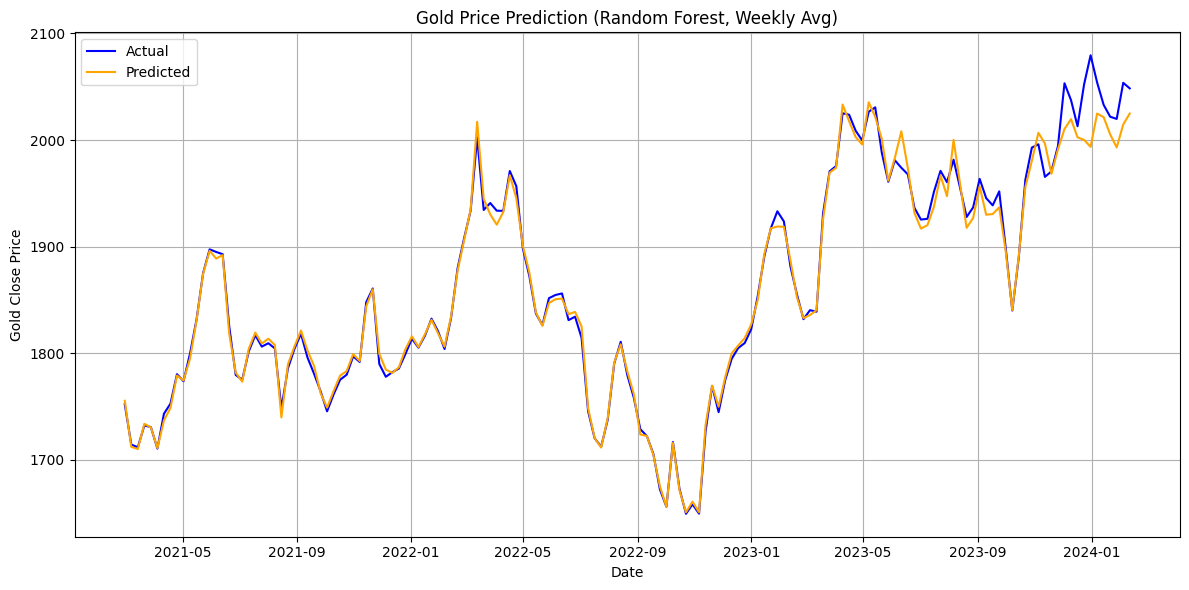

In [5]:
import matplotlib.pyplot as plt

# First, make sure your date column is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Resample test data to weekly (or monthly) to reduce clutter
test_plot = pd.DataFrame({
    'Date': df.loc[X_test.index, 'Date'],
    'Actual': y_test,
    'Predicted': y_pred
}).set_index('Date').resample('W').mean().dropna()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_plot.index, test_plot['Actual'], label='Actual', color='blue')
plt.plot(test_plot.index, test_plot['Predicted'], label='Predicted', color='orange')
plt.xlabel('Date')
plt.ylabel('Gold Close Price')
plt.title('Gold Price Prediction (Random Forest, Weekly Avg)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
def predict_price(date_str):
    date = pd.to_datetime(date_str)

    # Get latest known row to fill lag values
    latest = df.iloc[-1]

    # Build a single-row input DataFrame
    input_data = pd.DataFrame({
        'year': [date.year],
        'month': [date.month],
        'day': [date.day],
        'dayofweek': [date.dayofweek],
        'Close_lag1': [latest['Close']],
        'Close_lag7': [df.iloc[-7]['Close']],
        'Close_rolling7': [df['Close'].rolling(window=7).mean().iloc[-1]],
        'Close_pct_change': [(latest['Close'] - df.iloc[-2]['Close']) / df.iloc[-2]['Close']],
        'Open': [latest['Open']],
        'High': [latest['High']],
        'Low': [latest['Low']]
    })

    prediction = model.predict(input_data)[0]
    return round(prediction, 2)

# 🎯 Example usage:
future_date = "2025-04-20"
predicted_price = predict_price(future_date)
print(f"Predicted Gold Price for {future_date}: ${predicted_price}")

Predicted Gold Price for 2025-04-20: $1993.6800537109375
